In [123]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [124]:
path = './lfw'

In [125]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [126]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

torch.Size([250, 250, 3])


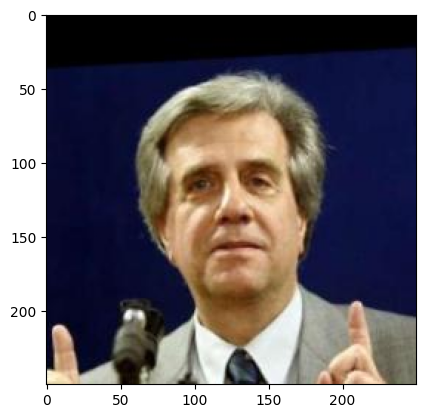

In [127]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

In [128]:
"""
The dimension torch.Size([250, 250, 3]) is the dimension of the image,
meaning that the image is 250x250 pixels with 3 channels (RGB).
"""

'\nThe dimension torch.Size([250, 250, 3]) is the dimension of the image,\nmeaning that the image is 250x250 pixels with 3 channels (RGB).\n'

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [129]:
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()

        self.encoderLayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.decoderLayer = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encoder(self, x):
        x = self.encoderLayer(x)
        return x

    def decoder(self, x):
        x = self.decoderLayer(x)
        return x

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [130]:
# Create an instance of the model
model = AE().to(device)

# Pass an image through the model
for x,y in dataloader:
    x = x.to(device)
    print(x.shape)
    x = model(x)
    print(x.shape)
    break

# Print the shape of the encoder layers
print("Encoder:")
for layer in model.encoderLayer:
    x = layer(x)
    print(x.shape)

# Print the shape of the decoder layers
print("Decoder:")
for layer in model.decoderLayer:
    x = layer(x)
    print(x.shape)

torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])
Encoder:
torch.Size([32, 64, 125, 125])
torch.Size([32, 64, 125, 125])
torch.Size([32, 128, 63, 63])
torch.Size([32, 128, 63, 63])
torch.Size([32, 256, 32, 32])
torch.Size([32, 256, 32, 32])
Decoder:
torch.Size([32, 128, 63, 63])
torch.Size([32, 128, 63, 63])
torch.Size([32, 64, 125, 125])
torch.Size([32, 64, 125, 125])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [131]:
# print total number of parameters in the model
print("Total parameters = {}".format(sum(p.numel() for p in model.parameters())))

Total parameters = 741379


In [132]:
optim = torch.optim.Adam(model.parameters(), lr=0.001) 

In [133]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [134]:
""""""
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)

        # forward
        output = model(img)
        loss = loss_function(output, img)
        
        # backward
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data

    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))

torch.save(model.state_dict(), './generated/conv_autoencoder.pth')


epoch [1/5], loss:2.5593
epoch [2/5], loss:0.3286
epoch [3/5], loss:0.2270
epoch [4/5], loss:0.1806
epoch [5/5], loss:0.1638


In [140]:
model.load_state_dict(torch.load('./generated/conv_autoencoder.pth'))

<All keys matched successfully>

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [141]:
def plot_image_pair(x,y):
    plt.subplot(121)
    plt.imshow(x.detach().cpu().squeeze().permute(1, 2, 0))
    plt.subplot(122)
    plt.imshow(y.detach().cpu().squeeze().permute(1, 2, 0))

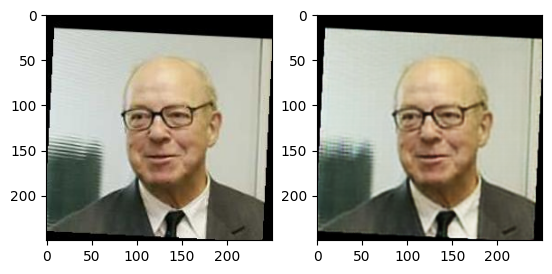

In [142]:
x, y = random.choice(dataloader.dataset)
x = x.to(device)
x = x.unsqueeze(0)

plot_image_pair(x,model(x))

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

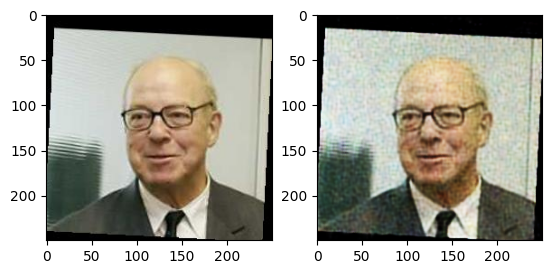

In [143]:
def add_noise(x, std=0.1):
  return x + torch.randn(x.size()).to(device) * std

plot_image_pair(x, model(add_noise(x)))

In [139]:
"""
Adding noise is affecting the decoded image by making it more blurry.
"""

'\nAdding noise is affecting the decoded image by making it more blurry.\n'